 # 서포트 벡터 머신 (SVM)

###  박태영 교수
### 연세대학교 응용통계학과

### Outline

### 2. 선형 SVM
    2.1 선형 SVM 학습
    2.2 규칙화 모수의 조정

#### 2.1 선형 SVM 학습

- 필요한 모듈을 설치

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches 

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

- 결정 경계 시각화를 위한 함수를 불러오기 위해 `mlxtend` 라이브러리를 설치

In [2]:
!pip install --upgrade pip
!pip install mlxtend

ERROR: To modify pip, please run the following command:
C:\Users\hopio\anaconda3\python.exe -m pip install --upgrade pip



  Using cached pip-23.2.1-py3-none-any.whl (2.1 MB)


- `mlxtend` 라이브러리를 설치한 뒤에 결정 경계 시각화에서 에러가 나는 것을 대비해 아래 두 줄의 코드를 차례대로 실행

In [3]:
conda install mlxtend --channel conda-forge

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [4]:
conda install -c conda-forge mlxtend

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


- 결정 경계 시각화를 위한 함수 설치

In [5]:
from mlxtend.plotting import plot_decision_regions

In [6]:
import warnings
warnings.filterwarnings(action='ignore')

- 포르투갈 은행이 2008년 5월부터 2010년 11월까지 고객을 대상으로 한 전화 설문에서 얻은 데이터와 해당 고객의 **정기 예금** 가입 여부(1:여, 0:부)
- 목적: 새로운 고객의 설문 데이터를 바탕으로 해당 고객이 향후 정기 예금에 가입할 지 예측
- 출처: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing     

In [7]:
data = pd.read_csv(r'C:\Users\hopio\Desktop\yonsei_practice\data\Bank.csv')
print(data.shape)
data.head()

(44700, 14)


,age,balance,duration,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,housing,loan,poutcome_other,poutcome_success,poutcome_unknown,y
0,58,2143,261,1,0,0,1,0,1,0,0,0,1,0
1,44,29,151,0,1,1,0,0,1,0,0,0,1,0
2,33,2,76,1,0,1,0,0,1,1,0,0,1,0
3,47,1506,92,1,0,0,0,1,1,0,0,0,1,0
4,33,1,198,0,1,0,0,1,0,0,0,0,1,0


In [8]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

- `X` 변수
   1. `age`: **나이** (numeric)
   2. `balance`: **연평균잔고(단위:유로)** (numeric) 
   3. `duration`: **마지막 접촉 이후 기간(단위:초)** (numeric)
   4. `marital_married`: **기혼 여부** ("married" or not)
   5. `marital_single`: **미혼 여부** ("single" or not)
   6. `education_secondary`: **중등교육 여부** ("secondary" or not)
   7. `education_tertiary`: **고등교육 여부** ("tertiary" or not)
   8. `education_unknown`: **교육수준의 결측 여부** ("secondary" or not)
   9. `housing`: **주택담보대출 여부** ("yes" or "no")
   10. `loan`: **개인신용대출 여부** ("yes" or "no")
   11. `poutcome_other`: **이전 마케팅의 결과는 other** ("yes" or "no")
   12. `poutcome_success`: **이전 마케팅의 결과는 성공** ("yes" or "no")
   13. `poutcome_unknown`: **이전 마케팅의 결과는 모름** ("yes" or "no")
   
   
- `y` 변수
    - `y`: **정기 예금 가입 여부** ("yes" or "no")

- 데이터 시각화: `balance`와 `duration`의 산점도

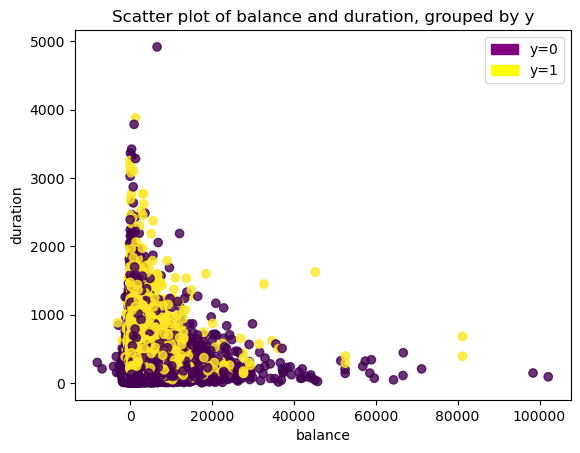

In [9]:
plt.scatter(X.iloc[:,1],X.iloc[:,2],c=y,alpha=.8)

plt.title('Scatter plot of balance and duration, grouped by y')
plt.xlabel('balance')
plt.ylabel('duration')
patch0 = mpatches.Patch(color='purple', label='y=0')
patch1 = mpatches.Patch(color='yellow', label='y=1')
plt.legend(handles=[patch0, patch1])
plt.savefig('Bank.png', dpi=300)
plt.show()

- 데이터의 70%를 훈련용(`train`)으로 사용하고 나머지 30%를 테스트용(`test`)으로 사용하기 위해 분리
- `stratify=y`를 사용하여 훈련용 데이터와 테스트용 데이터의 `y` 비율이 동일하게 함 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

- 훈련용 데이터의 `X_train`를 표준화 (평균이 0, 표준편차가 1)
- 표준화를 통해 학습의 안전성과 속도를 높임

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

sc.fit(X_train) # training data의 X에 대한 평균과 표준편차를 계산

X_train_std = sc.transform(X_train) # 표준화
X_test_std  = sc.transform(X_test) # 표준화

X_combined_std = np.vstack((X_train_std, X_test_std)) # 전체 데이터
y_combined = np.hstack((y_train, y_test)) # 전체 데이터

In [ ]:
print(np.mean(X_train_std), np.std(X_train_std))

In [ ]:
print(np.mean(X_test_std), np.std(X_test_std))

- 훈련용 데이터에 선형 SVM 학습

In [ ]:
svm = SVC(kernel='linear')
svm.fit(X_train_std, y_train)

- 테스트용 데이터에 선형 SVM 성능 측정

In [ ]:
y_pred = svm.predict(X_test_std)
confusion_matrix(y_test, y_pred)

In [ ]:
print('Misclassified samples: %d' % (y_test != y_pred).sum())

In [ ]:
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('Precision: %.2f' % precision_score(y_test, y_pred))
print('Recall: %.2f' % recall_score(y_test, y_pred))
print('F1: %.2f' % f1_score(y_test, y_pred))

#### 2.2 규칙화 모수의 조정

- `C`: 규칙화(regularization) 모수로 오분류를 어느정도 허용할 것인지를 결정 (디폴트 값은 1로서 항상 0보다 큰 값을 가짐)
- `C`가 클수록 오분류를 허용 안하고 (하드 마진), 작을수록 오분류를 허용함 (소프트 마진)

In [ ]:
data = pd.read_csv('Toy.csv')
X = data[['x1','x2']].values
y = data['y'].values
plt.scatter('x1','x2',c='y',data=data)
plt.show()

In [ ]:
scatter_kwargs = {'edgecolor': None, 'alpha': 0.7}
contourf_kwargs = {'alpha': 0.2}

In [ ]:
C=100
svm = SVC(kernel='linear', C=C, random_state=1)
svm.fit(X,y)
plot_decision_regions(X, y, clf=svm, 
                      scatter_kwargs=scatter_kwargs,
                      contourf_kwargs=contourf_kwargs)
plt.legend(loc='upper left')
plt.show()

In [ ]:
C=0.01
svm = SVC(kernel='linear', C=C, random_state=1)
svm.fit(X,y)
plot_decision_regions(X, y, clf=svm, 
                      scatter_kwargs=scatter_kwargs,
                      contourf_kwargs=contourf_kwargs)
plt.legend(loc='upper left')
plt.show()